# Bidirectional LSTM Sentiment Classifier

In this notebook, we use a *bidirectional* LSTM to classify IMDB movie reviews by their sentiment.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/the-deep-learners/deep-learning-illustrated/blob/master/notebooks/bi_lstm_sentiment_classifier.ipynb)

In [ ]:
# scikit-learn for Python3 - Jetson Xavier
# something in the following made it work:

# pip3 install --upgrade setuptools
# sudo pip3 install -U setuptools
# sudo apt-get install libpcap-dev libpq-dev
# sudo pip3 install cython

# finally!:

# sudo pip3 install git+https://github.com/scikit-learn/scikit-learn.git

# Other option
# pip install https://github.com/scikit-learn/scikit-learn/archive/0.20.1.tar.gz
# latest version https://github.com/scikit-learn/scikit-learn/archive/refs/tags/1.2.1.tar.gz


#### Load dependencies

In [1]:
%pip install -r /workspace/requirements_xavier.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 7.8 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 3.9 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 1.0 MB/s eta 0:00:00-:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 771.1/771.1 kB 14.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.

In [ ]:
# %set_env LD_PRELOAD=/usr/local/lib/python3.8/dist-packages/scikit_learn.libs/libgomp-d22c30c5.so.1.0.0
# %env

In [5]:
# %set_env LD_PRELOAD=/lib/aarch64-linux-gnu/libgomp.so.1
# %env

env: LD_PRELOAD=/lib/aarch64-linux-gnu/libgomp.so.1


{'NVIDIA_VISIBLE_DEVICES': 'all',
 'HOSTNAME': 'xavier-nx.apulache.io',
 'PWD': '/workspace',
 'NVIDIA_DRIVER_CAPABILITIES': 'all',
 'HOME': '/root',
 'CARGO_HOME': '/usr/local/cargo',
 'PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION': 'cpp',
 'TERM': 'xterm-color',
 'RUSTUP_HOME': '/usr/local/rustup',
 'SHLVL': '0',
 'LD_LIBRARY_PATH': '/usr/local/cuda/lib64:/usr/local/cuda/lib64:',
 'RUST_VERSION': '1.67.0',
 'CUDA_HOME': '/usr/local/cuda',
 'PATH': '/usr/local/cargo/bin:/usr/local/cuda/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin',
 'DEBIAN_FRONTEND': 'noninteractive',
 'OLDPWD': '/',
 '_': '/usr/local/bin/jupyter',
 'LC_CTYPE': 'C.UTF-8',
 'PYDEVD_USE_FRAME_EVAL': 'NO',
 'JPY_SESSION_NAME': '/workspace/568ca031-ef51-4088-b538-66cfecd089fa',
 'JPY_PARENT_PID': '1',
 'CLICOLOR': '1',
 'FORCE_COLOR': '1',
 'CLICOLOR_FORCE': '1',
 'PAGER': 'cat',
 'GIT_PAGER': 'cat',
 'MPLBACKEND': 'module://matplotlib_inline.backend_inline',
 'TF2_BEHAVIOR': '1',
 'KMP_

In [7]:
#import sklearn
#import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.layers import Bidirectional # new! 
from tensorflow.keras.callbacks import ModelCheckpoint
import os
# from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

#### Set hyperparameters

In [8]:
# output directory name:
output_dir = '/workspace/model_output/biLSTM'

# training:
epochs = 6
batch_size = 128

# vector-space embedding: 
n_dim = 64 
n_unique_words = 10000 
max_review_length = 200 # doubled!
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# LSTM layer architecture:
n_lstm = 256 
drop_lstm = 0.2

#### Load data

In [ ]:
# REF: https://github.com/tensorflow/tensorflow/commit/79a8d5cdad942b9853aa70b59441983b42a8aeb3#diff-b0a029ad68170f59173eb2f6660cd8e0
# apt update && apt install nano -y
# sudo nano /usr/local/lib/python3.8/dist-packages/keras/datasets/imdb.py
# -  with np.load(path) as f:
# +  with np.load(path, allow_pickle=True) as f:

In [9]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip

17464789/17464789 [==============================] - 3s 0us/step


#### Preprocess data

In [10]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Design neural network architecture

In [11]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))
model.add(Dense(1, activation='sigmoid'))

2023-02-07 22:50:45.447455: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:977] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-07 22:50:45.849989: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:977] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-07 22:50:45.852088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:977] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-07 22:50:45.865517: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:977] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-07 22:50:45.866500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:977] could not op

In [12]:
# LSTM layer parameters double due to both reading directions
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 64)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 512)              657408    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 1,297,921
Trainable params: 1,297,921
Non-trainable params: 0
_________________________________________________________________


#### Configure model

In [13]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [15]:
# - with this toy dataset, the complex interplay of words over long sentence segments, won't be learned much
# - so our CNN picking up location-invariant segments of two to four words that predict review sentiment
# - these are simpler and so easier to learn from the data
# - CNN therefore outperforms on the IMDB data set
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/6


2023-02-07 22:51:51.092715: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


196/196 [==============================] - 112s 424ms/step - loss: 0.5586 - accuracy: 0.7058 - val_loss: 0.3611 - val_accuracy: 0.8463
Epoch 2/6
196/196 [==============================] - 79s 401ms/step - loss: 0.2942 - accuracy: 0.8811 - val_loss: 0.3076 - val_accuracy: 0.8742
Epoch 3/6
196/196 [==============================] - 78s 398ms/step - loss: 0.2232 - accuracy: 0.9148 - val_loss: 0.3149 - val_accuracy: 0.8711
Epoch 4/6
196/196 [==============================] - 79s 402ms/step - loss: 0.1804 - accuracy: 0.9333 - val_loss: 0.3351 - val_accuracy: 0.8630
Epoch 5/6
196/196 [==============================] - 78s 400ms/step - loss: 0.1567 - accuracy: 0.9434 - val_loss: 0.4404 - val_accuracy: 0.8439
Epoch 6/6
196/196 [==============================] - 78s 398ms/step - loss: 0.1362 - accuracy: 0.9511 - val_loss: 0.3713 - val_accuracy: 0.8480


#### Evaluate

In [19]:
model.load_weights(output_dir+"/weights.04.hdf5") 

In [21]:
y_hat = model.predict(x_valid)

782/782 [==============================] - 43s 49ms/step


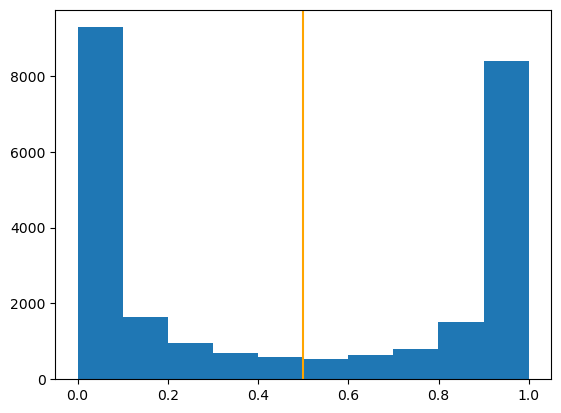

In [22]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [23]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

NameError: name 'roc_auc_score' is not defined